In [1]:
using Revise

In [2]:
using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue,
    LinearAlgebra,
    Printf,
    Plots,
    Random,
    StatsBase
;

using Distributions

import MutableNamedTuples: MutableNamedTuple
import StructArrays: StructArray, StructVector
import StaticArrays: @SVector, SVector
import LinearAlgebra: norm, ⋅, adjoint!, diag
import LoopVectorization: @turbo
using BenchmarkTools
using Parameters
using LsqFit

import ProgressMeter: Progress, next!

const λ = 626e-9
const Γ = 2π* 6.4e6
const m = @with_unit 57 "u"
const k = 2π / λ
_μB = (μ_B / h) * 1e-4;

include("CaOH_scan_helper_repump_Christian.jl")
working_dir = "C:\\Google Drive\\github\\OpticalBlochEquations\\examples\\ipynb_sources\\toy_models\\CaOH_scan"
;

In [108]:
function survived(t_end, times, trajectories)
    _survived = Int64[]
    for i ∈ eachindex(trajectories)
        if times[i][end] ≈ t_end*1e3
            push!(_survived, i)
        end
    end
    return _survived
end

function cloud_size_std(trajectories, i)
    std(trajectory[i] for trajectory ∈ trajectories if length(trajectory) >= i)
end

"""
    Evaluates the density given a set of trajectories.
"""
function density(t_end, results)
    
    times, x_trajectories, y_trajectories, z_trajectories = results.times, results.x_trajectories, results.y_trajectories, results.z_trajectories
    
    # Sample number of photons before the molecule is lost to vibrational dark state
    n_molecules = length(times)
    
    _survived = survived(t_end, times, x_trajectories)
    println(_survived)
    
    surviving_x_trajectories = x_trajectories[_survived]
    surviving_y_trajectories = y_trajectories[_survived]
    surviving_z_trajectories = z_trajectories[_survived]
    
    n = length(_survived)
    _density = Float64(n)
    if n > 1
        idx_end = length(surviving_x_trajectories[1])
        σ_x = cloud_size(surviving_x_trajectories, idx_end)
        σ_y = cloud_size(surviving_y_trajectories, idx_end)
        σ_z = cloud_size(surviving_z_trajectories, idx_end)
        _density /= σ_x * σ_y * σ_z
    end
    return _density
end

function distance(x_trajectory, y_trajectory, z_trajectory, idx)
    return sqrt(x_trajectory[idx]^2 + y_trajectory[idx]^2 + z_trajectory[idx]^2)
end

goodness_val(r) = r <= 0.8 ? (0.8 - r)^3 : 0
"""
    Evaluates how many particles are within a 0.3 mm radius.
"""
function goodness(t_end, results)
    
    times, x_trajectories, y_trajectories, z_trajectories = results.times, results.x_trajectories, results.y_trajectories, results.z_trajectories
    
    # Sample number of photons before the molecule is lost to vibrational dark state
    n_molecules = length(times)
    
    _survived = survived(t_end, times, x_trajectories)
    @printf("Survival: %i / %i", length(_survived), n_molecules)
    println()
    
    surviving_x_trajectories = x_trajectories[_survived]
    surviving_y_trajectories = y_trajectories[_survived]
    surviving_z_trajectories = z_trajectories[_survived]
    
    n = 0
    for survived_idx ∈ _survived
        idx_end = length(x_trajectories[survived_idx])
        r = distance(x_trajectories[survived_idx], y_trajectories[survived_idx], z_trajectories[survived_idx], idx_end)
        n += goodness_val(r)
    end
    return n/n_molecules
end

using LsqFit

function Gaussian(x, p)
    σ, x0, A = p
   return A * exp.(-(x.-x0).^2/(2*σ^2)) 
end

function exponential(x, p)
    σ, A = p
   return A * exp.(-x.^2/(2*σ^2))
end

# function distance_to_center(results, _survived)
    
#     xs = [distance(results.x_trajectories[survived_idx], results.y_trajectories[survived_idx], results.z_trajectories[survived_idx], idx_end) for survived_idx ∈ _survived]

#     hist_data = fit(Histogram, xs, nbins=10)
#     hist_data.isdensity = true
#     v = collect(hist_data.edges[1])
#     dv = v[2]-v[1]
#     v = v[1:end-1] .+ dv/2
#     fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

#     v_fit = curve_fit(exponential, v, fv, [0.3, 3.])
#     σ, A = v_fit.param

function cloud_size(i, trajectories)
    
    xs = [trajectory[i] for trajectory ∈ trajectories]

    hist_data = fit(Histogram, xs, -0.7:0.1:0.7)
    hist_data.isdensity = true
    v = collect(hist_data.edges[1])
    dv = v[2]-v[1]
    v = v[1:end-1] .+ dv/2
    fv = hist_data.weights ./ (sum(hist_data.weights) * dv)

    v_fit = curve_fit(Gaussian, v, fv, [0.5, 0., 1])
    σ, x0, A = v_fit.param
    
    return σ
end
;

### Set up the molecule

In [4]:
package = get_CaOH_package()
n_states = length(package.states)
n_excited = package.n_excited
;

##### Scan a single configuration

In [621]:
s1 = 3.00 #1.47
s2 = 0.00 # but can be 0
s3 = 5.06
s4 = 4.45
Δ1 = +2.41Γ
Δ2 = -2.30Γ
Δ3 = +2.41Γ
Δ4 = -6.53Γ
B_gradient = -30
ramp_time = 10e-3

# current config
# s1 = 1.00*2.5
# s2 = 0.00
# s3 = 1.50*2.5
# s4 = 2.00*3.0
# Δ1 = +2.00Γ
# Δ2 = -2.00Γ
# Δ3 = Δ1
# Δ4 = Δ1 - 8.9Γ
# ramp_time = 10e-3
# B_gradient = -20

###
# s1 = 2.9525082413112442
# s2 = 0.00
# s3 = 1.6509590867606776
# s4 = 4.738939337340759
# Δ1 = +3.7291212568408656Γ
# Δ2 = -2.00Γ
# Δ3 = Δ1
# Δ4 = -8.0Γ
# B_gradient = -33

# model optimum, 10 ms ramp, can ramp longer to get smaller loss
s1=2.8136633472867225
s3=2.983223276482847
s4=6.608722792430141
Δ1=Δ3=2.7753193486393464Γ
Δ4=-6.612907886107669Γ
grad=-37.851510639415295
repump_rate=0.777411805681385

# observed optimum
# s1=3.1104054145778988
# s3=2.505754170833177
# s4=7.210004466499433
# Δ1=Δ3=2.7673712312624867Γ
# Δ4=-5.93411501187565Γ
# grad=-42.41456636202009
# repump_rate=0.6041171450783487

# model optimum, 20 ms ramp time
s1=2.0041389574440864
s3=2.7814520186297367
s4=4.663206769039553
Δ1=Δ3=2.132417920162393Γ
Δ4=-6.564322679637441Γ
grad=-39.413954281604795
repump_rate=0.1949275546092989

ramp_time = 20e-3

#
s1=3.6981337653269484
s3=2.7886099432142304
s4=8.414940213060348
Δ1=Δ3=1.9971689672780215Γ
Δ4=-7.016215810104207Γ
grad=-37.76284789673129
repump_rate=0.11430962613949382
ramp_time=30.0e-3

# s1=2.990907793676668
# s3=1.9973783847584845
# s4=5.900456471396321
# Δ1=Δ3=2.9472644820801803Γ
# Δ4=-8.575765086171895Γ
# grad=-29.53102740434516
# repump_rate=0.13377565989203527
# ramp_time=30.128162747376997e-3

# current config
s1=5.9*13.5/15.6
s3=7.7*13.5/15.6
s4=2.0*13.5/15.6
Δ1=Δ3=+1.97Γ
Δ4=-6.94Γ
grad=-30
repump_rate=10
ramp_time=10.0e-3

# current config, long ramp, limited repump
# s1=5.9*13.5/15.6
# s3=7.7*13.5/15.6
# s4=2.0*13.5/15.6
# Δ1=Δ3=+1.97Γ
# Δ4=-6.94Γ
# grad=-30
# repump_rate=0.1
# ramp_time=30.0e-3

# other side of F=2
s1=2
s3=2
s4=0.0
Δ1=+1.0Γ
Δ3=+1.0Γ - 2π * 2.3e6
Δ4=-6.94Γ
grad=+40
repump_rate=10
ramp_time=20.0e-3

s2=0.
Δ2=0.

dark_lifetime = 1/(repump_rate * 0.1e6)
temp = @with_unit 0.050 "mK"
diameter = @with_unit 1.0 "mm"
displacement = [0.0, 0.0, 0.0]
kick = [0,0, 0.0, 0.0]

params = MutableNamedTuple(t_end = 30e-3, n_values = 200,
                           pol1_x=σ⁻, pol2_x=σ⁻, pol3_x=σ⁺, pol4_x=σ⁻, 
                           s1=s1, s2=s2, s3=s3, s4=s4,
                           Δ1=Δ1, Δ2=Δ2, Δ3=Δ3, Δ4=Δ4, 
                           B_gradient = grad, 

                           temp=temp, diameter=diameter, 
                           displacement=displacement, kick=kick,
                           ramp_time = ramp_time,
                           photon_budget=15000, dark_lifetime=dark_lifetime, FC_mainline=0.95,

                           pol_imbalance=0.02,
                           s_imbalance = (0.1, 0.1, 0.1), retro_loss=0.0,

                           off_center=[1,1,1,1,1,1].*1e-3,
                           pointing_error =[0., 0., 0, 0, 0, 0]
)

results = simulate_particles_repump(package, params)
;

Progress: 100%|█████████████████████████████████████████| Time: 0:06:16


In [627]:
_survived = survived(params.t_end, results.times, results.x_trajectories)
surviving_x_trajectories = results.x_trajectories[_survived]
surviving_y_trajectories = results.y_trajectories[_survived]
surviving_z_trajectories = results.z_trajectories[_survived]
length(_survived) |> display
;

30

In [628]:
idx_end = length(surviving_x_trajectories[1])
cloud_size(idx_end, surviving_x_trajectories) |> display
cloud_size(idx_end, surviving_y_trajectories) |> display
cloud_size(idx_end, surviving_z_trajectories) |> display
cloud_size_std(surviving_x_trajectories, idx_end) |> display
cloud_size_std(surviving_y_trajectories, idx_end) |> display
cloud_size_std(surviving_z_trajectories, idx_end) |> display

0.06912653919321968

0.07218411529168137

0.06631974064421434

0.19003949079027999

0.286827691509268

1.0130871789443305

In [629]:
mean(results.photons_scattered[_survived] ./ 30e-3)

763987.7777777779

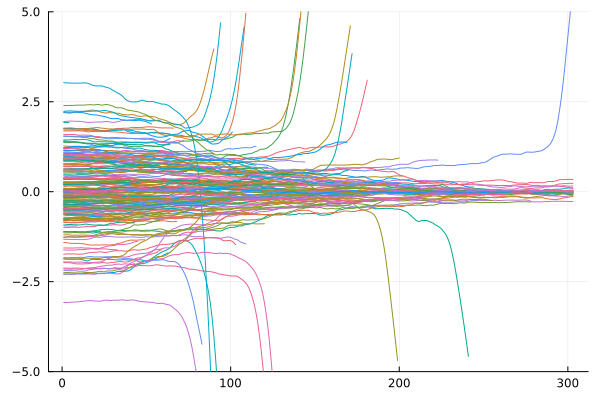

In [633]:
plot(results.z_trajectories, legend=nothing, ylim=(-5,5))

In [626]:
goodness(params.t_end, results)

Survival: 30 / 200


0.04347207096110221

In [5]:
"""
    Function to optimize (density).
"""
function f(x)
    s1 = x[1]
    s3 = x[2]
    s4 = x[3]
    Δ1 = x[4]*Γ
    Δ3 = Δ1
    Δ4 = x[5]*Γ
    # ramp_time = 10e-3
    # ramp_time = 20e-3
    B_gradient = -x[6]
    repump_rate = x[7]
    ramp_time = x[8] * 1e-3

    temp = @with_unit 0.050 "mK"
    diameter = @with_unit 2.0 "mm"
    displacement = [0.0, 0.0, 0.0]
    kick = [0,0, 0.0, 0.0]
    
    params = MutableNamedTuple(t_end = 40e-3, n_values = 20,
                           pol1_x=σ⁻, pol2_x=σ⁻, pol3_x=σ⁺, pol4_x=σ⁻, 
                           s1=s1, s2=0., s3=s3, s4=s4,
                           Δ1=Δ1, Δ2=0., Δ3=Δ3, Δ4=Δ4,
                           B_gradient = B_gradient,

                           temp=temp, diameter=diameter, 
                           displacement=displacement, kick=kick,
                           ramp_time = ramp_time,
                           photon_budget=15000, dark_lifetime=1/(repump_rate * 0.1e6), FC_mainline=0.95,

                           pol_imbalance=0.02,
                           s_imbalance = (0.1, 0.1, 0.1), retro_loss=0.0,

                           off_center=[2,2,2,2,2,2].*1e-3,
                           pointing_error =[0., 0., 0, 0, 0, 0]
    )
    
    results = simulate_particles_repump(package, params)
    
    @printf("s1 = %.2f; s3 = %.2f; s4 = %.2f; Δ1 = %.2f Γ; Δ3 = Δ1; Δ4 = %.2f Γ; B = %.2f; repump_rate = %.2f; ramp_time = %.2f", x[1], x[2], x[3], x[4], x[5], x[6], x[7], x[8])
    println()
    
    _goodness = goodness(params.t_end, results)
    @printf("goodness = %.3f", _goodness * 1e3)
    println()
    
    return _goodness * 1e3
end
;    

In [29]:
using BayesianOptimization, GaussianProcesses

model = ElasticGPE(8,                            # 6 input dimensions
                   mean = MeanConst(1.),         
                   kernel = SEArd([1., 1, 1, 1, 1, 1, 1, 1], 5.),
                   logNoise = 0.,
                   capacity = 3000)              # the initial capacity of the GP is 3000 samples
set_priors!(model.mean, [Normal(0., 0.01)])

# Optimize the hyperparameters of the GP using maximum a posteriori (MAP) estimates every x steps
modeloptimizer = MAPGPOptimizer(
    every = 1, 
    noisebounds = [-3, 3], # bounds of the logNoise
    kernbounds = [[-3, -3, -3, -3, -3, -3, -3, -3, -5], [3, 3, 3, 3, 3, 3, 3, 3, 5]],  # bounds of the parameters GaussianProcesses.get_param_names(model.kernel)
    maxeval = 1000
)

opt = BOpt(f,
           model,
           UpperConfidenceBound(),             # type of acquisition
           modeloptimizer,
           initializer_iterations = 0,
           # initializer_iterations = 200,
           [0.0, 0.0, 0.0, +0.0, -10.0, 0, 0, 0],        # lowerbounds
           [7.0, 7.0, 10., +7.0, -0.0, 50, 3, 40],        # upperbounds         
           repetitions = 1,                          # evaluate the function for each input x times
           maxiterations = 0,                       # evaluate at x input positions
           sense = Max,                              # maximize the function
           acquisitionoptions = (method = :LD_LBFGS, # run optimization of acquisition function with NLopts :LD_LBFGS method
                                 restarts = 10,       # run the NLopt method from x random initial conditions each time
                                 maxtime = 5.0,      # run the NLopt method for at most 1.0 second each time
                                 maxeval = 5000),    # run the NLopt methods for at most 1000 iterations (for other options see https://github.com/JuliaOpt/NLopt.jl)
           verbosity = BayesianOptimization.Progress)

result = boptimize!(opt)
;

┌ Info:  ────────────────────────────────────────────────────────────────────────
│                                 Time                    Allocations      
│                        ───────────────────────   ────────────────────────
│    Tot / % measured:        271μs /  87.0%           51.4KiB /  86.6%    
│ 
│  Section       ncalls     time    %tot     avg     alloc    %tot      avg
│  ────────────────────────────────────────────────────────────────────────
│  acquisition        1    236μs  100.0%   236μs   44.5KiB  100.0%  44.5KiB
└  ────────────────────────────────────────────────────────────────────────


In [775]:
using BayesianOptimization, GaussianProcesses
using Serialization
opt = deserialize(joinpath(working_dir, "optimized_3freqs_with_imperfections_fullscan_density.jl"))
;

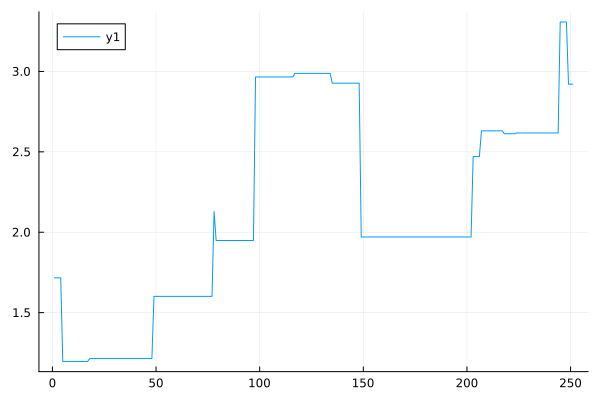

In [781]:
moving_average(vs,n) = [sum(@view vs[i:(i+n-1)])/n for i in 1:(length(vs)-(n-1))]
plot(moving_average(opt.model.y, 200))

In [782]:
opt.observed_optimum

203.3324175066165

In [783]:
opt.observed_optimizer

8-element Vector{Float64}:
  2.449896059521965
  1.5014115792298035
  8.739591173248618
  1.1394968937633154
 -7.34300159242822
 25.278914770693774
  0.4200648912239083
 22.736258949638597

In [784]:
opt.model_optimum

0.00031253092977151633

In [785]:
opt.model_optimizer

8-element Vector{Float64}:
  5.0288286724654
  3.7506595939041447
  9.074036134929115
  4.99440076860777
 -1.6060790386308739
 16.177255768005928
  1.0692414960418806
 25.128896487953575

In [342]:
function output_config(optimizer, variables)
    print(reduce(*, variables[i] * "=" * string(optimizer[i]) * "\n" for i ∈ eachindex(optimizer)))
end
;

In [341]:
output_config(opt.model_optimizer, variables)

s1=3.2840524186606266
s3=2.3915277338029144
s4=7.224241838746298
Δ1=Δ3=0.8790601235888928
Δ4=-1.7660756581272299
grad=29.791092483158657
repump_rate=1.9584648912687805
ramp_time=5.573177932920995


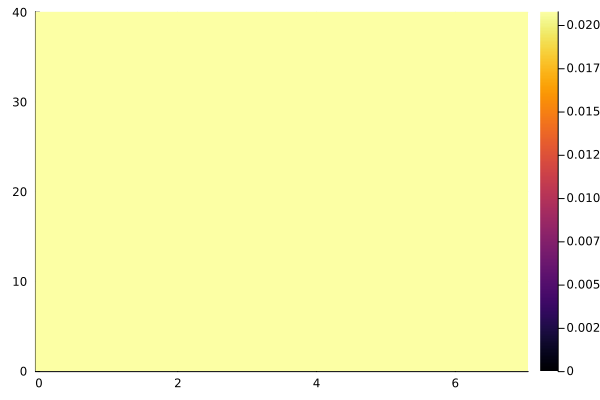

In [358]:
# variables = ["s1", "s2", "s3", "s4", "Δ1=Δ3", "Δ2", "Δ4"]
variables = ["s1", "s3", "s4", "Δ1=Δ3", "Δ4", "grad", "repump_rate", "ramp_time"]

idx1 = 1
idx2 = 8

list1 = opt.lowerbounds[idx1]:0.1:opt.upperbounds[idx1]
list2 = opt.lowerbounds[idx2]:0.1:opt.upperbounds[idx2]

preds_mat = zeros(length(list1), length(list2))
points = zeros(8, 1)

for (i, val1) ∈ enumerate(list1)
    for (j, val2) ∈ enumerate(list2)
        points[:,1] .= opt.model_optimizer
        points[idx1,1] = val1
        points[idx2,1] = val2
        preds_mat[i,j] = predict_y(opt.model, points)[1][1]
    end
end
heatmap(list1, list2, preds_mat')
# scatter!(opt.model.x[idx1,:], opt.model.x[idx2,:], legend=nothing, xlabel=variables[idx1], ylabel=variables[idx2])